In [1]:
###############################  Data Preprocessing  ################################

#import necessary libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

In [2]:
#read the datasets and store it in a dictionary
raw_data = {}
raw_data['AAPL'] = pd.read_csv('/kaggle/input/stockdata/AAPL.csv')
raw_data['AMZN'] = pd.read_csv('/kaggle/input/stockdata/AMZN.csv')
raw_data['FB'] = pd.read_csv('/kaggle/input/stockdata/FB.csv')
raw_data['GOOG'] = pd.read_csv('/kaggle/input/stockdata/GOOG.csv')
raw_data['INTC'] = pd.read_csv('/kaggle/input/stockdata/INTC.csv')
raw_data['MSFT'] = pd.read_csv('/kaggle/input/stockdata/MSFT.csv')
raw_data['NFLX'] = pd.read_csv('/kaggle/input/stockdata/NFLX.csv')
raw_data['ORCL'] = pd.read_csv('/kaggle/input/stockdata/ORCL.csv')
raw_data['TSLA'] = pd.read_csv('/kaggle/input/stockdata/TSLA.csv')
raw_data['WMT'] = pd.read_csv('/kaggle/input/stockdata/WMT.csv')

In [3]:
#store the datasets in a dictionary, keep only the closing price
datas = {}
for name,data in raw_data.items():
    datas[name] = raw_data[name]['Close'].reset_index()

#store the closing price columns of each dataset in a dictionary
CP_dict = {}
for name,data in datas.items():
    CP_dict[name] = datas[name]['Close']

#convert the dictionary to a dataframe    
CP_df = pd.DataFrame(CP_dict)

In [4]:
###############################  MC Simulation  ####################################

#first, calculate the annual return and volatility with equal weights

#daily log return for each asset and store within the dataframe
daily_return = np.log(CP_df.pct_change() + 1).dropna()
#mean daily return for each asset
daily_return_mean = np.array(daily_return.mean())
#assigning equal weight of 0.1 (1/10) for each asset
weights = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
#portfolio return can now be calculated as
Port_return = np.sum(weights * daily_return_mean)

#covariance for each asset
cov = daily_return.cov()
#portfolio volatility
Port_Vol = np.sqrt(np.dot(weights.T,np.dot(cov,weights)))

In [5]:
#the same calculations will now be done M times with different weight combos
#Declare the number of Portfolio to be generated
num_portfolio = 30000

#an empty list for storing annual returns, volatility, sharpe ratio 
#and weightage of each stock in the generated portfolios
results = np.zeros((3 + len(daily_return.columns),num_portfolio))

#Monte Carlo simulation loop
for i in range(num_portfolio):
    
    #sample random weights from standard uniform
    weight = np.random.rand(len(daily_return.columns)) 
    #ensure that sum of all weight equal to 1
    weight = weight/np.sum(weight) 
    
    #Annual return
    p_annual_return = np.sum(weight*daily_return_mean)*252 
    #Annual volatility
    p_annual_volatility = np.sqrt(np.dot(weight.T,np.dot(cov,weight)))*np.sqrt(252) 
    
    #Storing the values in results list
    results[0,i] = p_annual_return
    results[1,i] = p_annual_volatility
    results[2,i] = results[0,i]/results[1,i]

    for j in range(len(weight)):
        results[j+3,i] =  weight[j]
 
        
#store all the results in a single dataframe
cols = ['Ann_Ret','Ann_Vol','Sharpe_Ratio']
for num in range(len(list(daily_return.columns))):
    cols.append(list(daily_return.columns)[num])

#resulting dataframe
result_df = pd.DataFrame(results.T,columns=cols)


In [6]:
###############################  Summary Statistics  ################################

#portfolio I : Max Sharpe ratio
max_sharpe_ratio = result_df.iloc[result_df['Sharpe_Ratio'].idxmax()]
print('The portfolio with the maximum Sharpe_Ratio is:')
print('All values in percentage')
print(round(max_sharpe_ratio * 100,2))

#portfolio II : Min Sharpe ratio
min_sharpe_ratio = result_df.iloc[result_df['Sharpe_Ratio'].idxmin()]
print('The portfolio with the minimum Sharpe_Ratio is:')
print('All values in percentage')
print(round(min_sharpe_ratio * 100,2))

#portfolio III : Max annual volatility
volatility_highest = result_df.iloc[result_df['Ann_Vol'].idxmax()]
print('The portfolio with the maximum volatility is:')
print('All values in percentage')
print(round(volatility_highest * 100,2))

#portfolio IV : Min annual volatility
volatility_lowest = result_df.iloc[result_df['Ann_Vol'].idxmin()]
print('The portfolio with the minimum volatility is:')
print('All values in percentage')
print(round(volatility_lowest * 100,2))

The portfolio with the maximum Sharpe_Ratio is:
All values in percentage
Ann_Ret          35.75
Ann_Vol          14.36
Sharpe_Ratio    248.93
AAPL              0.94
AMZN              1.72
FB                0.26
GOOG             12.52
INTC              3.45
MSFT             26.55
NFLX              0.83
ORCL             26.95
TSLA              8.52
WMT              18.27
Name: 5094, dtype: float64
The portfolio with the minimum Sharpe_Ratio is:
All values in percentage
Ann_Ret         11.80
Ann_Vol         16.85
Sharpe_Ratio    70.01
AAPL             2.33
AMZN            13.23
FB               6.62
GOOG             8.65
INTC            28.77
MSFT             1.55
NFLX             5.68
ORCL             0.48
TSLA             4.54
WMT             28.15
Name: 10693, dtype: float64
The portfolio with the maximum volatility is:
All values in percentage
Ann_Ret          29.87
Ann_Vol          25.25
Sharpe_Ratio    118.28
AAPL             10.13
AMZN              0.16
FB               14.22
GOOG 

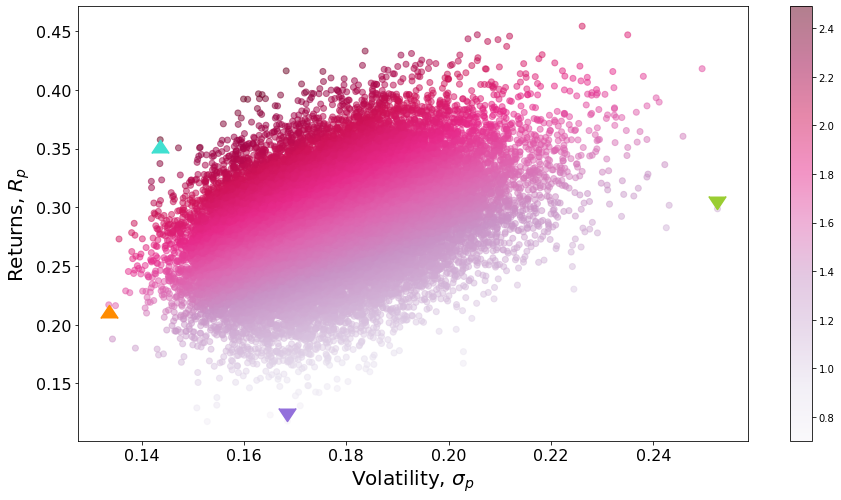

In [7]:
###############################  Visualizations  ####################################

#Fig 1 : return vs risk

fig=plt.figure(figsize=(15,8))
plt.scatter(result_df['Ann_Vol'],result_df['Ann_Ret'], \
            c=result_df['Sharpe_Ratio'],cmap='PuRd',alpha=0.5)
plt.colorbar()

plt.scatter(max_sharpe_ratio[1],max_sharpe_ratio[0], \
            marker = 6,color='turquoise',s=300) #portfolio I
plt.scatter(min_sharpe_ratio[1],min_sharpe_ratio[0], \
            marker = 7,color='mediumpurple',s=300) #portfolio II
plt.scatter(volatility_highest[1],volatility_highest[0], \
            marker = 7,color='yellowgreen',s=300) #portfolio III
plt.scatter(volatility_lowest[1],volatility_lowest[0], \
            marker = 6,color='darkorange',s=300)#portfolio IV

plt.xlabel('Volatility, $\sigma_p$',fontsize = 20)
plt.ylabel('Returns, $R_p$',fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()
fig.savefig('riskVSreturn.pdf', dpi=200)

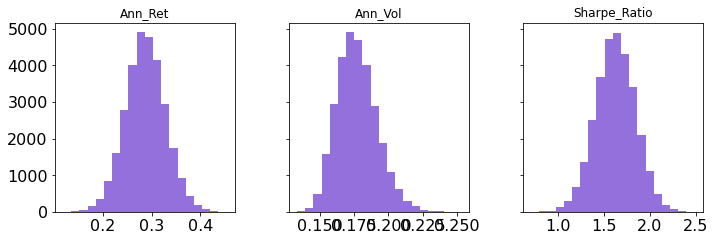

In [8]:
#Fig 2 : dist of annual return, volatility and Sharpe ratio

result_df[['Ann_Ret', 'Ann_Vol', 'Sharpe_Ratio']].hist(bins=20, \
                figsize=(20, 8),layout=(2,5),grid=False, \
                xlabelsize=16,ylabelsize=16,sharex=False,sharey=True, \
                density=False, color='mediumpurple',alpha=1.0)
plt.savefig('histAnn.pdf')

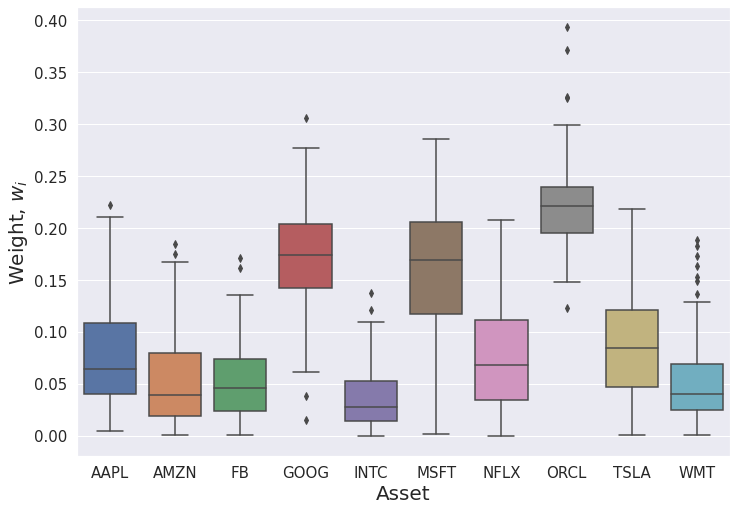

In [9]:
#Fig 3 : weight distritbuion for top 100 portfolios with highest Sharpe ratio

top_df = result_df.sort_values(by='Sharpe_Ratio',ascending=False)
top_df = top_df.drop(['Ann_Ret', 'Ann_Vol', 'Sharpe_Ratio'], axis=1)

sns.set(rc={'figure.figsize':(11.7,8.27)})
b=sns.boxplot(data=top_df.iloc[0:100:,:])
b.set_xlabel("Asset",fontsize=20)
b.set_ylabel("Weight, $w_i$",fontsize=20)
b.tick_params(labelsize=15)
fig = b.get_figure()
fig.savefig('boxTop.pdf')

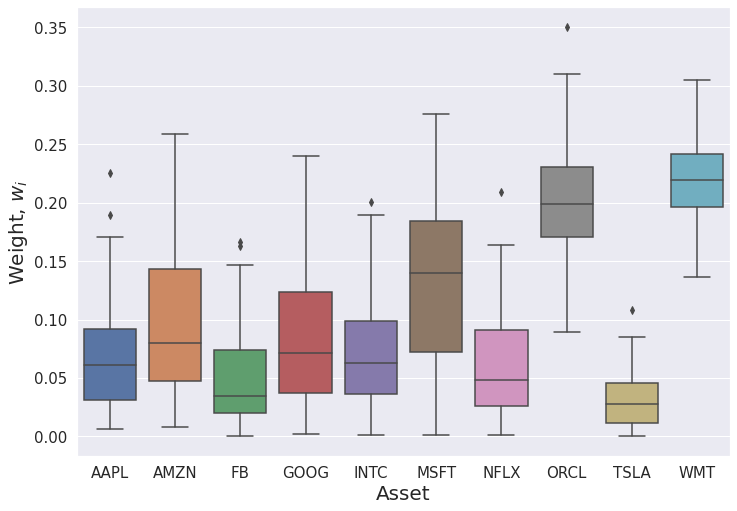

In [10]:
#Fig 4 : weight distritbuion for top 100 portfolios with lowest annual volatility

top_df2 = result_df.sort_values(by='Ann_Vol',ascending=True)
top_df2 = top_df2.drop(['Ann_Ret', 'Ann_Vol', 'Sharpe_Ratio'], axis=1)

sns.set(rc={'figure.figsize':(11.7,8.27)})
b=sns.boxplot(data=top_df2.iloc[0:100:,:])
b.set_xlabel("Asset",fontsize=20)
b.set_ylabel("Weight, $w_i$",fontsize=20)
b.tick_params(labelsize=15)
fig = b.get_figure()
fig.savefig('boxTop2.pdf')

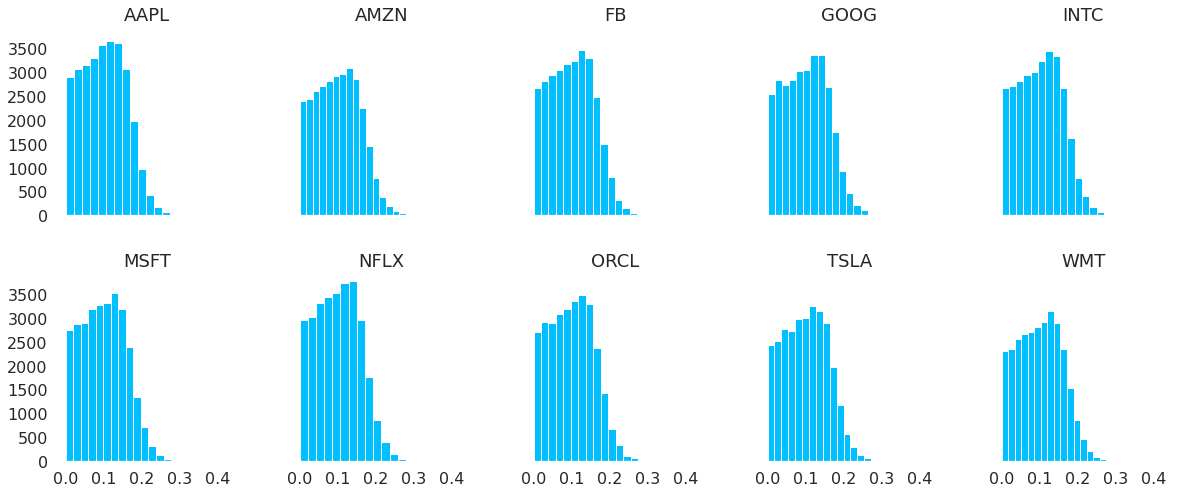

In [11]:
###############################  Extra  ############################################

#Visulising the result dataframe
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.titlesize']='18'

df_stocks = result_df.drop(['Ann_Ret', 'Ann_Vol', 'Sharpe_Ratio'], axis=1)
myplot=df_stocks.hist(bins=20, figsize=(20, 8),layout=(2,5),grid=False, \
              xlabelsize=16,ylabelsize=16,sharex=True,sharey=True, \
              density=False, color='deepskyblue',alpha=1.0)
plt.savefig('histFet.pdf') 